# 4. Classification

In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis # LDA
from sklearn.metrics import confusion_matrix,classification_report,precision_score
from sklearn import preprocessing, neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# Load Dataset
df = pd.read_excel('../data/Default.xlsx')
# df.head()

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

/opt/homebrew/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


### Figure 4.1 - Default data set

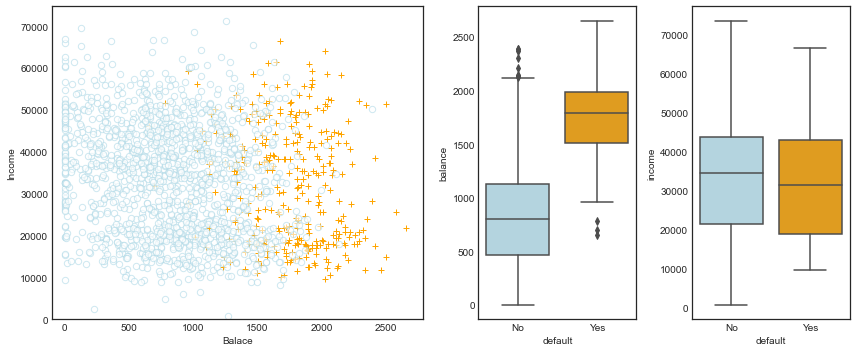

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1,4)
     #location of  plots, think about the 4, and try 2, 3
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac = 0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

# Scatter Plot
ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income,
                    s = 40, c = 'orange', marker = '+', linewidths =1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income,
                    s = 40, marker = 'o', linewidths =1,
                    edgecolors = 'lightblue', facecolors = 'white', alpha = 0.6)
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin= -100)
ax1.set(xlabel='Balace', ylabel='Income')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x='default', y = 'balance', data=df, 
                        # bug here, set:x='default', y = 'balance'
                    orient='v', ax=ax2,palette=c_palette)
sns.boxplot(x = 'default', y = 'income', data=df, 
                    orient='v', ax=ax3,palette=c_palette)
gs.tight_layout(plt.gcf())

FIGURE4.1 Default data set

Left: The annual incomes and monthly credit card balances of a number of individuals. 
The individuals who defaulted on their credit card payments are shown in orange, and those who did not are shown in blue.

 Center: Boxplots of balance as a function of default status. 

 Right: Boxplots of income as a function of default status.

## Logistic Regression
### Figure 4.2

In [4]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2
# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

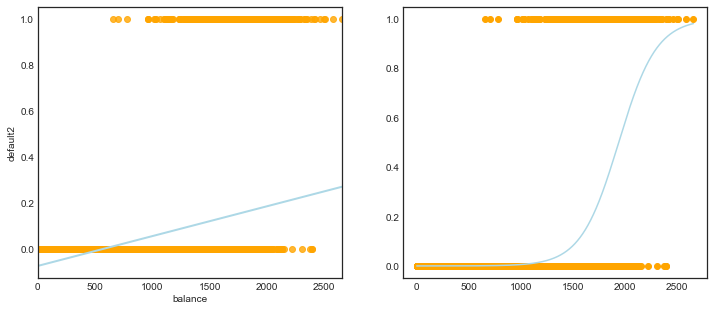

In [5]:
clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

_, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(x = df.balance, y = df.default2, order=1, ci=None,
                    #note here:(x = 'x', y = 'y') as the sns new rule
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)

    ax.set(xlabel='Probability of default', ylabel='Balace')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

FIGURE 4.2. Classification using the Default data.

Left: Estimated probability of default using linear regression. 
Some estimated probabilities are negative.
The orange ticks indicate the 0/1 values coded for default (No or Yes).

 Right: Predicted probabilities of default using logistic regression. All probabilities lie between 0 and 1.

### Table 4.1

In [6]:
y = df.default2
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
clf = skl_lm.LogisticRegression(solver = 'newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train, y)
print(clf,f"Classes: {clf.classes_}, Coefficients: {clf.coef_}, Intercept: {clf.intercept_}")

LogisticRegression(solver='newton-cg') Classes: [0 1], Coefficients: [[0.00549891]], Intercept: [-10.6513214]


In [7]:
X_train = sm.add_constant(df.balance)

est = sm.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


/opt/homebrew/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


TABLE 4.1. For the Default data, estimated coefficients of the logistic regression model that predicts the probability of default using balance.

A one-unit increase in balance is associated with an increase in the log odds of default by 0.0055 units.

**note**:.ravel() is equivalent to reshape(-1, order=order).

In [8]:
est.summary() # summary2

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Aug 2021   Pseudo R-squ.:                  0.4534
Time:                        16:39:59   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                6.233e-290
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0.000     24.952      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Table 4.2

In [9]:
df.head()

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0
3,4,No,No,529.250605,35704.493935,0,0
4,5,No,No,785.655883,38463.495879,0,0


In [10]:
X_train = sm.add_constant(df.student2)
y = df.default2
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


/opt/homebrew/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


TABLE 4.2. For the Default data, estimated coefficients of the**logistic regression model **that predicts the probability of default using student status.

 Student status is encoded as a **dummy variable**, with a value of 1 for a student and a value of 0 for a non-student, and represented by the variable **student[Yes]** in the table.

In [11]:
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.004     
Dependent Variable: default2         AIC:              2912.6831 
Date:               2021-08-02 16:39 BIC:              2927.1037 
No. Observations:   10000            Log-Likelihood:   -1454.3   
Df Model:           1                LL-Null:          -1460.3   
Df Residuals:       9998             LLR p-value:      0.00054161
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const        -3.5041    0.0707  -49.5541  0.0000  -3.6427  -3.3655
student2      0.4049    0.1150    3.5202  0.0004   0.1795   0.6303
=================================================================

"""

### Table 4.3 - Multiple Logistic Regression

In [12]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


/opt/homebrew/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


In [13]:
est.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.462      
Dependent Variable: default2         AIC:              1579.5448  
Date:               2021-08-02 16:40 BIC:              1608.3862  
No. Observations:   10000            Log-Likelihood:   -785.77    
Df Model:           3                LL-Null:          -1460.3    
Df Residuals:       9996             LLR p-value:      3.2575e-292
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
const       -10.8690    0.4923  -22.0793  0.0000  -11.8339  -9.9042
balance       0.0057    0.0002   24.7365  0.0000    0.0053   0.0062
income        0.0000    0.0000    0.3698  0.7115   -0.0000   0.0000
student2     -0.6468    0.2363   -2.7376  0.0062   -1.1098  -0.1837
==================================================================

"""

### Figure 4.3 Confounding

In [14]:
# Balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size, 1)
        # df[df.student == 'Yes'].balance.values : value of the df[df.student == 'Yes'].balance 
        #df[df.student == 'Yes'].balance.size = size of the students'balace
y= df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1 )
y2 = df[df.student == 'No'].default2

# Vector with balance values for  plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver = 'newton-cg')
clf_2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train, y)
clf_2.fit(X_train2, y2)

prob = clf.predict_proba(X_test)
prob2 = clf_2.predict_proba(X_test)


In [15]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


/opt/homebrew/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Student'), Text(0, 0.5, 'Balance')]

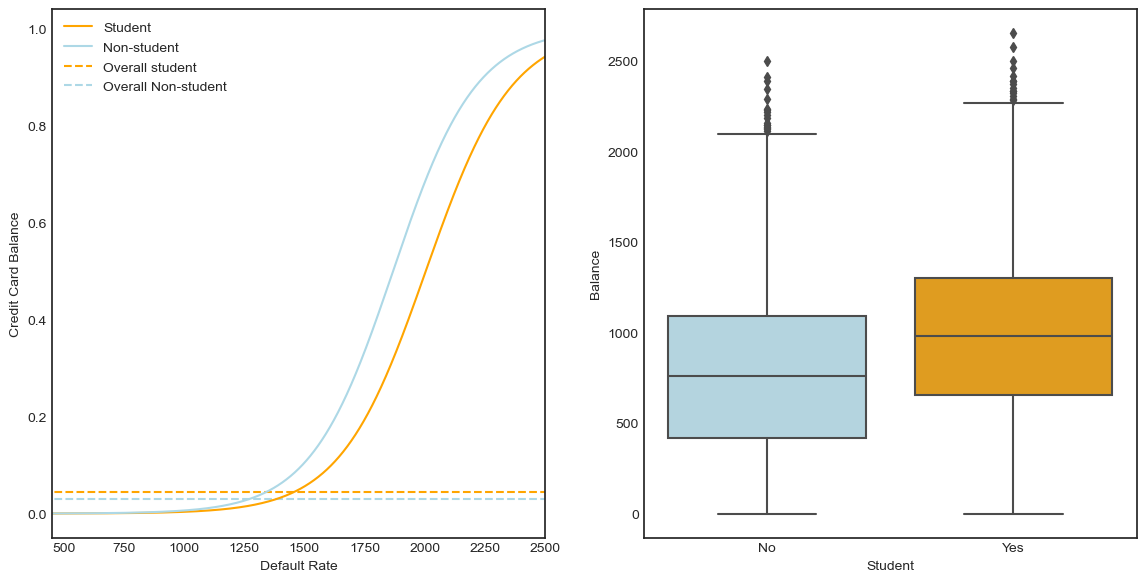

In [16]:
# Plot
_ , (ax1, ax2) = plt.subplots(1, 2, figsize =(14,7), dpi = 100)

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color = 'orange',label = 'Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color = 'lightblue',label = 'Non-student')
    # Overall students' and non-students' case
ax1.hlines(127/2817, colors = 'orange',label = 'Overall student',
                    xmin = ax1.xaxis.get_data_interval()[0],
                    xmax = ax1.xaxis.get_data_interval()[1], linestyles = 'dashed') 
ax1.hlines(206/6850, colors = 'lightblue',label = 'Overall Non-student',
                    xmin = ax1.xaxis.get_data_interval()[0],
                    xmax = ax1.xaxis.get_data_interval()[1], linestyles = 'dashed') 

ax1.set(xlabel='Default Rate', ylabel='Credit Card Balance')
ax1.set_yticks([0, .2, .4 ,.6, .8, 1])
ax1.set_xlim(450, 2500)
ax1.legend(loc="best")

# Right plot
sns.boxplot('student','balance', data=df,
                    orient='v',ax=ax2,palette=c_palette)
ax2.set(xlabel='Student', ylabel='Balance')

FIGURE 4.3. Confounding in the Default data.

Left: Default rates are shown for students (orange) and non-students (blue). The solid lines display default rate as a function of balance, while the horizontal broken lines display the overall default rates. 

Right: Boxplots of balance for students (orange) and non-students (blue) are shown.

## Linear Discriminant Analysis
### Table 4.4

In [60]:
df.head()

,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.5265,44361.6251,0,0
1,2,No,Yes,817.1804,12106.1347,0,1
2,3,No,No,1073.5492,31767.1389,0,0
3,4,No,No,529.2506,35704.4939,0,0
4,5,No,No,785.6559,38463.4959,0,0


In [83]:
X = df[['balance', 'income', 'student2']]
y = df.default2 # no more as_matrix

In [84]:
lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True Default Status':y,
                                    'Predicted Default Status':y_pred})
# df_.head()
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)
# df_.head()
# df_.groupby(['Predicted Default Status', 'True Default Status']).size()
df_.groupby(['Predicted Default Status', 'True Default Status']).size().unstack('True Default Status')

True Default Status,No,Yes
Predicted Default Status,,
No,9645,254
Yes,22,79


In [86]:
# print(classification_report(y, y_pred))
print(classification_report(y, y_pred, target_names= ['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



# The Stock Market Data

In [18]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
%precision 4
pd.set_option('precision', 4)

We will begin by examining some numerical and graphical summaries of the `Smarket` data. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was Up or Down on this date).

In [19]:
market = pd.read_csv('../data/Smarket.csv')
market = market.rename(columns = {'Unnamed: 0':'Day'})
market.head()

,Day,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [20]:
market.shape

(1250, 10)

In [21]:
market.describe()

,Day,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.0000,1250.000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000
mean,625.5000,2003.016,0.0038,0.0039,0.0017,0.0016,0.0056,1.4783,0.0031
std,360.9882,1.409,1.1363,1.1363,1.1387,1.1388,1.1476,0.3604,1.1363
min,1.0000,2001.000,-4.9220,-4.9220,-4.9220,-4.9220,-4.9220,0.3561,-4.9220
25%,313.2500,2002.000,-0.6395,-0.6395,-0.6400,-0.6400,-0.6400,1.2574,-0.6395
50%,625.5000,2003.000,0.0390,0.0390,0.0385,0.0385,0.0385,1.4230,0.0385
75%,937.7500,2004.000,0.5968,0.5968,0.5968,0.5968,0.5970,1.6417,0.5968
max,1250.0000,2005.000,5.7330,5.7330,5.7330,5.7330,5.7330,3.1525,5.7330


The corr() method produces a matrix that contains all of the pairwise correlations among the predictors in a data set.

In [22]:
market.corr(method='pearson')

,Day,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Day,1.0000,0.9798,0.0354,0.0360,0.0390,0.0414,0.0350,0.5463,0.0353
Year,0.9798,1.0000,0.0297,0.0306,0.0332,0.0357,0.0298,0.5390,0.0301
Lag1,0.0354,0.0297,1.0000,-0.0263,-0.0108,-0.0030,-0.0057,0.0409,-0.0262
Lag2,0.0360,0.0306,-0.0263,1.0000,-0.0259,-0.0109,-0.0036,-0.0434,-0.0103
Lag3,0.0390,0.0332,-0.0108,-0.0259,1.0000,-0.0241,-0.0188,-0.0418,-0.0024
Lag4,0.0414,0.0357,-0.0030,-0.0109,-0.0241,1.0000,-0.0271,-0.0484,-0.0069
Lag5,0.0350,0.0298,-0.0057,-0.0036,-0.0188,-0.0271,1.0000,-0.0220,-0.0349
Volume,0.5463,0.5390,0.0409,-0.0434,-0.0418,-0.0484,-0.0220,1.0000,0.0146
Today,0.0353,0.0301,-0.0262,-0.0103,-0.0024,-0.0069,-0.0349,0.0146,1.0000


As one would expect, the correlations between the lag variables and today's returns are close to zero. In other words, there appears to be little correlation between today's returns and previous days' returns. The only substantial correlation is between `Year` and `Volume`. By plotting the data we see that `Volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

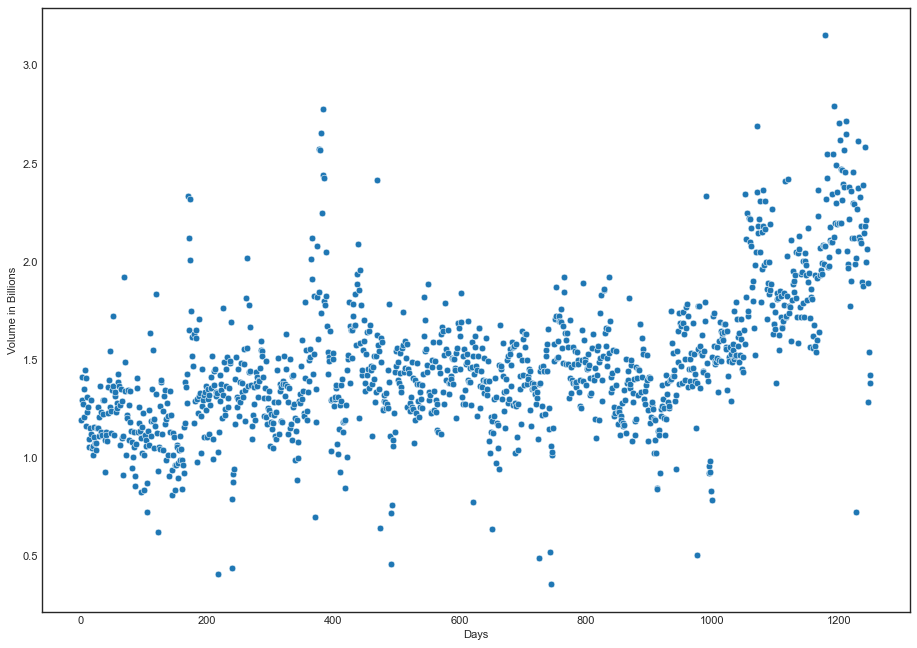

In [23]:
_, ax = plt.subplots(figsize=(14,10),dpi = 80)

ax = sns.scatterplot(x='Day', y='Volume', data=market)
ax.set(xlabel='Days')
ax.set(ylabel='Volume in Billions')
plt.show()

# Logistic Regression

Next, we will fit a logistic regression model in order to predict `Direction` using `Lag1` through `Lag5` and `Volume`. The `logit()` creates a logistic regression instance. We can use a formula similar to the ones we have used, before we need to code the response; otherwise we must specify the matrices for the predictors and the response.

In [24]:
# Encode the response as 0,1 for down/up
market['DirCoded'] = [0 if d == 'Down' else 1 for d in market.Direction]
market.head()

,Day,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCoded
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


## statsmodels solution

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### build model

In [26]:
f = 'DirCoded ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
logit_fit = smf.logit(f, market).fit()
logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               DirCoded   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Aug 2021   Pseudo R-squ.:                0.002074
Time:                        16:40:01   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest p-value here is associated with `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value
is still relatively large, and so there is no clear evidence of a real association between `Lag1` and `Direction`.

We use the `params` method in order to access just the coefficients for this fitted model. We can also use the `summary()` function to access particular aspects of the fitted model, such as the p-values for the coefficients.

In [27]:
logit_fit.params

Intercept   -0.1260
Lag1        -0.0731
Lag2        -0.0423
Lag3         0.0111
Lag4         0.0094
Lag5         0.0103
Volume       0.1354
dtype: float64

The `predict()` function can be used to predict the probability that the market will go up, given values of the predictors (as a data frame). The output is of the form P (Y = 1|X). If no data set is supplied to the predict() function, then the probabilities are computed for the training data that was used to fit the logistic regression model. Here we have printed only the first ten probabilities. We know that these values correspond to the probability of the market going up, rather than down, because we have created a dummy variable with a 1 for Up.

In [28]:
logit_probs = logit_fit.predict(market)
logit_probs[:10]

0    0.5071
1    0.4815
2    0.4811
3    0.5152
4    0.5108
5    0.5070
6    0.4927
7    0.5092
8    0.5176
9    0.4888
dtype: float64

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, `Up` or `Down`. The following commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than 0.5.

In [29]:
market['logit_pred'] = ['Up' if p > 0.5 else 'Down' for p in logit_probs]

table = pd.crosstab(market.Direction, market.logit_pred)
table

logit_pred,Down,Up
Direction,,
Down,145,457
Up,141,507


We can now build a confusion matrix in order to determine how many observations were correctly or incorrectly classified.

In [30]:
print('The model made {} correct predictions on the TRAINING SET.'.format((table.Down[0] + table.Up[1])/logit_fit.nobs))      

The model made 0.5216 correct predictions on the TRAINING SET.


The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence our model correctly predicted that the market would go up on 507 days and that it would go down on 145 days, for a total of 507 + 145 = 652 correct predictions. The mean() function can be used to compute the fraction of
days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market 52.2 % of the time.

In [31]:
np.mean(market.logit_pred == market.Direction)

0.5216

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the model on the same set of 1,250 observations. In other words, 100 − 52.2 = 47.8 % is the training error rate. As we have seen previously, the training error rate is often overly optimistic - it tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model's performance not on the data that we used to fit the model, but rather on days in the future for which the
market's movements are unknown.

To implement this strategy, we will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.

### split dataset

In [32]:
train_df = market[market.Year < 2005]
test_df = market[market.Year == 2005]
test_df.shape

(252, 12)

In [33]:
train_df.shape

(998, 12)

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005. We then obtain predicted probabilities of the stock market going up for
each of the days in our test set - that is, for the days in 2005.

In [34]:
f = 'DirCoded ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
logit_fit = smf.logit(f, train_df).fit()
predicted_probs = logit_fit.predict(test_df)
predicted_probs

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


998     0.5282
999     0.5157
1000    0.5227
1001    0.5139
1002    0.4983
         ...  
1245    0.4836
1246    0.5060
1247    0.5167
1248    0.5161
1249    0.5081
Length: 252, dtype: float64

Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005. Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [35]:
test_df['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]
print('The model made', np.mean(test_df.preds == test_df.Direction),'% correct predictions on the TEST SET.')

table = pd.crosstab(test_df.Direction, test_df.preds)
table

The model made 0.4801587301587302 % correct predictions on the TEST SET.


/var/folders/bz/8yf5rf0s1yzd3gl6nw6xvclw0000gn/T/ipykernel_11822/162314525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]


preds,Down,Up
Direction,,
Down,77,34
Up,97,44


In [36]:
table = logit_fit.pred_table(threshold=0.5)

confusion_df = pd.DataFrame(table, ['Down','Up'], ['Down','Up'])
confusion_df

,Down,Up
Down,175.0,316.0
Up,156.0,351.0


In [37]:
print('The model made', np.mean(test_df.preds != test_df.Direction),'% incorrect predictions on the TEST SET.')

The model made 0.5198412698412699 % incorrect predictions on the TEST SET.


The != notation means not equal to, and so the last command computes the test set error rate. The results are rather disappointing: the test error rate is 52 %, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to use previous days' returns to predict future market performance.

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to `Lag1`. Perhaps by removing the variables that appear not to be helpful in predicting Direction, we can obtain a more effective model. After all, using predictors that have no
relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we have refit the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [38]:
train_fit = smf.logit('DirCoded ~ Lag1 + Lag2', train_df).fit()
predicted_probs = train_fit.predict(test_df)
test_df['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]
print('The model made', np.mean(test_df.preds == test_df.Direction),'% correct predictions on the TEST SET.')
table = pd.crosstab(test_df.preds, test_df.Direction)
table

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3
The model made 0.5595238095238095 % correct predictions on the TEST SET.


/var/folders/bz/8yf5rf0s1yzd3gl6nw6xvclw0000gn/T/ipykernel_11822/564322119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]


Direction,Down,Up
preds,,
Down,35,35
Up,76,106


In [39]:
print('On days where the prediction day is \'Up\' the probability the market will be \'Up\' is',
      table['Up']['Up']/(table['Down']['Up'] + table['Up']['Up']))

On days where the prediction day is 'Up' the probability the market will be 'Up' is 0.5824175824175825


Now the results appear to be a little better: 56% of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will
also be correct 56% of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular values of `Lag1` and `Lag2`. In particular, we want to predict `Direction` on a day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when they equal 1.5 and -0.8. We do this using the predict() function.

In [40]:
train_fit.predict(pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1,-0.8]}))

0    0.4791
1    0.4961
dtype: float64

## sklearn solution

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [42]:
market.head()

,Day,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCoded,logit_pred
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1,Down
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0,Down
3,4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1,Up
4,5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1,Up


In [43]:
logit_fit.params

Intercept    0.1912
Lag1        -0.0542
Lag2        -0.0458
Lag3         0.0072
Lag4         0.0064
Lag5        -0.0042
Volume      -0.1163
dtype: float64

In [44]:
def loading(train_df, test_df, predictors, goal='DirCoded'):
    X_train = train_df[predictors]
    y_train = train_df[goal]
    X_test = test_df[predictors]
    y_test = test_df[goal]
    return X_train, y_train, X_test, y_test

In [45]:
def classify(clf, data, coef=True, auc=False, roc_curve=False, conf_mat=False, conf_labels=['Down', 'Up']):
    X_train, y_train, X_test, y_test = data[0], data[1], data[2], data[3]

    model = clf.fit(X_train, y_train)
    if coef:
        print('parameters: {}'.format(clf.coef_))
    
    acc = clf.score(X_test, y_test)
    print('accuracy: {}'.format(acc))
    
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred)
    print('precision: {}'.format(precision))
    
    recall = recall_score(y_test, y_pred)
    print('recall: {}'.format(recall))
    
    mat = confusion_matrix(y_test, y_pred)
    print('confusion matrix \n{}'.format(mat))
    
    if auc:
        y_score = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
        print('auc: {}'.format(auc))
    
    if roc_curve:
        plot_roc_curve(clf, X_test, y_test)
    
    if conf_mat:
        plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                              display_labels=conf_labels)
    
    return clf

In [46]:
predictors = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
data = loading(train_df, test_df, predictors, goal='DirCoded')
log_clf = LogisticRegression(solver='lbfgs', tol=0.0001)
logreg = classify(log_clf, data)

parameters: [[-0.0541 -0.0456  0.0073  0.0065 -0.0042 -0.11  ]]
accuracy: 0.48412698412698413
precision: 0.5647058823529412
recall: 0.3404255319148936
confusion matrix 
[[74 37]
 [93 48]]


In [47]:
predictors = ['Lag1', 'Lag2', 'Volume']
data = loading(train_df, test_df, predictors, goal='DirCoded')
logreg = classify(log_clf, data)

parameters: [[-0.0541 -0.0458 -0.1137]]
accuracy: 0.4801587301587302
precision: 0.5641025641025641
recall: 0.3120567375886525
confusion matrix 
[[77 34]
 [97 44]]


In [48]:
predictors = ['Lag1', 'Lag2']
data = loading(train_df, test_df, predictors, goal='DirCoded')
logreg = classify(log_clf, data)

parameters: [[-0.0554 -0.0444]]
accuracy: 0.5595238095238095
precision: 0.5824175824175825
recall: 0.75177304964539
confusion matrix 
[[ 35  76]
 [ 35 106]]


In [49]:
X_try = pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1,-0.8]})
exp = logreg.predict_proba(X_try)
print('0: {}\n1: {}'.format(exp[:,1][0], exp[:,1][1]))

0: 0.4792246508480524
1: 0.49614354134986477


# Linear Discriminant Analysis

Now we will perform LDA on the `Smarket` data. In Python, we fit an LDA model using the `LinearDiscriminantAnalysis` function, which is part of the `sklearn` module.We fit the model using only the observations before 2005.

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [51]:
predictors = ['Lag1','Lag2']
data = loading(train_df, test_df, predictors, goal='DirCoded')
lda_clf = LDA()
lda_clf = classify(lda_clf, data)

parameters: [[-0.0554 -0.0443]]
accuracy: 0.5595238095238095
precision: 0.5824175824175825
recall: 0.75177304964539
confusion matrix 
[[ 35  76]
 [ 35 106]]


In [52]:
print('Class Priors\nDown: {}\nUp: {}\n'.format(lda_clf.priors_[0], lda_clf.priors_[1]))
print('Class Means\nDown: {}\nUp: {}\n'.format(lda_clf.means_[0], lda_clf.means_[1]))
print('Coeffecients\nLag1: {}\nLag2: {}\n'.format(lda_clf.scalings_[0], lda_clf.scalings_[1]))

Class Priors
Down: 0.49198396793587174
Up: 0.5080160320641283

Class Means
Down: [0.0428 0.0339]
Up: [-0.0395 -0.0313]

Coeffecients
Lag1: [-0.642]
Lag2: [-0.5135]



The LDA output indicates that $\pi_1 = 0.492$ and $\pi_2 = 0.508$; in other words, 49.2 % of the training observations correspond to days during which the market went down. It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$ . These suggest that there is a tendency for the previous 2 days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines. The coefficients of linear discriminants output provides the linear
combination of Lag1 and Lag2 that are used to form the LDA decision rule. In other words, these are the multipliers of the elements of $X = x$ in (4.19). If $-0.642 \times Lag1 - 0.514 \times Lag2$ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline. 

The predict_proba() function returns a matrix whose k$^{th}$ column contains the posterior probability that the corresponding observation belongs to the k$^{th}$ class, computed from (4.10). 

As we observed in the previous section, the LDA and logistic regression predictions are almost identical.

Applying a 50 % threshold to the posterior probabilities allows us to recreate the predictions contained in lda_pred_class.

In [53]:
lda_pred_posterior = lda_clf.predict_proba(data[2])
print(np.mean(lda_pred_posterior))
lda_pred_posterior[:20,0]

0.49999999999999994


array([0.4902, 0.4792, 0.4668, 0.474 , 0.4928, 0.4939, 0.4951, 0.4873,
       0.4907, 0.4844, 0.4907, 0.512 , 0.4895, 0.4707, 0.4745, 0.48  ,
       0.4936, 0.5031, 0.4979, 0.4886])

If we wanted to use a posterior probability threshold other than 50 % in order to make predictions, then we could easily do so. For instance, suppose that we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day-say, if the posterior probability is at least 90 %.

In [54]:
np.sum(lda_pred_posterior[:,0] >= 0.9)

0

No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was 52.02 %

In [55]:
np.max(lda_pred_posterior[:,0])

0.5202349505356155

# Quadratic Discriminant Analysis

We will now fit a QDA model to the Smarket data. QDA is implemented in the sklearn module. The qda() syntax is identical to that of lda().

In [56]:
predictors = ['Lag1','Lag2']
data = loading(train_df, test_df, predictors, goal='DirCoded')
qda_clf = QDA()
qda_clf = classify(qda_clf, data, coef=False)

accuracy: 0.5992063492063492
precision: 0.599009900990099
recall: 0.8581560283687943
confusion matrix 
[[ 30  81]
 [ 20 121]]


In [57]:
print('Class Priors\nDown: {}\nUp: {}\n'.format(qda_clf.priors_[0], qda_clf.priors_[1]))
print('Class Means\nDown: {}\nUp: {}\n'.format(qda_clf.means_[0], qda_clf.means_[1]))
print('Coeffecients\nLag1: {}\nLag2: {}\n'.format(qda_clf.scalings_[0], qda_clf.scalings_[1]))

Class Priors
Down: 0.49198396793587174
Up: 0.5080160320641283

Class Means
Down: [0.0428 0.0339]
Up: [-0.0395 -0.0313]

Coeffecients
Lag1: [1.5629 1.4793]
Lag2: [1.5346 1.4727]



The output contains the group means. But it does not contain the coefficients of the linear discriminants, because the QDA classifier involves a quadratic, rather than a linear, function of the predictors. The predict() function works in exactly the same fashion as for LDA.

Interestingly, the QDA predictions are accurate almost 60 % of the time, even though the 2005 data was not used to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite hard to model accurately. This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression. However, we recommend evaluating this method’s performance on a larger test set before betting that this approach will consistently beat the market!

In [58]:
def plot_bayesian_boundary(clf, data, X1, X2):
    fig, ax = plt.subplots(figsize=(8,8))
    X_train, y_train, X_test, y_test = data[0], data[1], data[2], data[3]
    ax.scatter(X_train[y_train==1][X1], X_train[y_train==1][X2], alpha=0.7, label='Up')
    ax.scatter(X_train[y_train==0][X1], X_train[y_train==0][X2], alpha=0.7, label='Down')

    nx, ny = 200, 200
    x_min, x_max = ax.set(xlim=())
    y_min, y_max = ax.set(ylim=())
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    cp = ax.contour(xx, yy, Z, [0.5], linewidths=1., colors='k');
    plt.clabel(cp, inline=True, fmt='Bayes Decision Boundary', fontsize=8)

    ax.set(xlabel='Lag1')
    ax.set(ylabel='Lag2')
    ax.legend(loc='best')

ValueError: not enough values to unpack (expected 2, got 0)

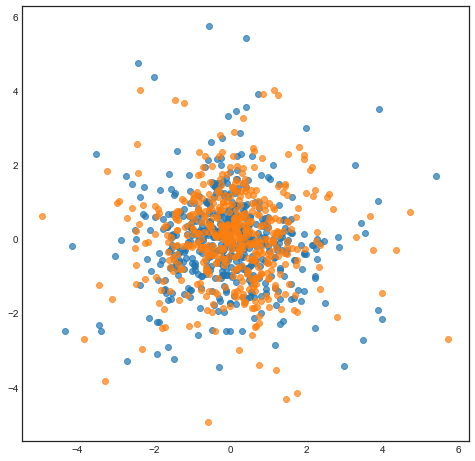

In [59]:
plot_bayesian_boundary(lda_clf, data, 'Lag1', 'Lag2')

In [ ]:
plot_bayesian_boundary(qda_clf, data, 'Lag1', 'Lag2')

# K-Nearest Neighbors

We will now perform KNN using the KNeighborsClassifier() function, which is part of the sklearn module. We start by initiating and instance of the classifier with K=1. To fit the model we need to pass a matrix of the predictors, and a vector with the corresponding class labels.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNNC

In [ ]:
predictors = ['Lag1','Lag2']
data = loading(train_df, test_df, predictors, goal='DirCoded')
knn = KNNC(n_neighbors=1)
knn = classify(knn, data, coef=False)

Now the knn() function can be used to predict the market's movement for the dates in 2005.

Below, we repeat the analysis using K = 3.

In [ ]:
knn3 = KNNC(n_neighbors=3)
knn3 = classify(knn3, data, coef=False)

The results have improved slightly. But increasing K further turns out to provide no further improvements. It appears that for this data, QDA provides the best results of the methods that we have examined so far.

Note the confusion matrix is off by one from the text. This is likely due to the fact that some neighbors are equidistant from a one of the points. In R you can set a random seed to reproduce which one is chosen. In sklearn, the choice is based on the order the points appear in the data.

# An Application to Caravan Insurance Data

## look at the dataset

In [ ]:
from sklearn.preprocessing import StandardScaler

Finally, we will apply the KNN approach to the `Caravan` data set. This data set includes 85 predictors that measure
demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.

In [ ]:
caravan = pd.read_csv('data/Caravan.csv', index_col=0)
caravan.head()

In [ ]:
caravan.shape

In [ ]:
des = caravan.Purchase.describe()
des

In [ ]:
print('The probability an individual purchased car insurance was,',
      1- des.freq / caravan.shape[0])

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters. Any variables that are on a large scale will have a much larger

effect on the distance between the observations, and hence on the KNN classifier, than variables that are on a small scale. For instance, imagine a data set that contains two variables, salary and age (measured in dollars and years, respectively). As far as KNN is concerned, a difference of \\$1,000 in salary is enormous compared to a difference of 50 years in age. Consequently, salary will drive the KNN classification results, and age will have almost no effect. This is contrary to our intuition that a salary difference of \\$1,000 is quite small compared to an age difference of 50 years. Furthermore, the importance of scale to the KNN classifier leads to another issue: if we measured salary in Japanese yen, or if we measured age in minutes, then we'd get quite different classification results from what we get if these two variables are measured in dollars and years.

A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale. In standardizing the data, we exclude column 86, because that is the qualitative Purchase variable.

In [ ]:
print(np.var(caravan.iloc[:,0]))
print(np.var(caravan.iloc[:,1]))

In [ ]:
scaler = StandardScaler()
caravan.iloc[:,0:85] = scaler.fit_transform(caravan.iloc[:,0:85])

NameError: name 'StandardScaler' is not defined

In [ ]:
print(np.var(caravan.iloc[:,0]))
print(np.var(caravan.iloc[:,1]))

Now every column of X has a standard deviation of one and a mean of zero.

We now split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations. We fit a KNN model on the training data using K = 1, and evaluate its performance on the test data.

In [ ]:
caravan.Purchase

NameError: name 'caravan' is not defined

In [ ]:
caravan.Purchase = np.array([0 if i=='No' else 1 for i in caravan.Purchase.values])

In [ ]:
caravan.Purchase

NameError: name 'caravan' is not defined

## build model

In [ ]:
predictors = caravan.columns.tolist()[:-1]

train_df = caravan[1000:]
test_df = caravan[:1000]

data_knn = loading(train_df, test_df, predictors, goal='Purchase')

knn = KNNC(n_neighbors=1)
knn = classify(knn, data_knn, coef=False)

NameError: name 'caravan' is not defined

In [ ]:
knn_pred = knn.predict(data_knn[2])

error_rate = np.mean(knn_pred != data_knn[3])

print('The error rate for k={0:d} is {1:.3f} %'.format(1, 100*error_rate))
print('There are {} % custumors who bought insurance on the test set.'.format(np.mean(data_knn[3] != 0)))

The KNN error rate on the 1,000 test observations is just below 12 %. At first glance, this may appear to be fairly good. However, since only 6 % of customers purchased insurance, we could get the error rate down to 6 % by always predicting No regardless of the values of the predictors!

Suppose that there is some non-trivial cost to trying to sell insurance to a given individual. For instance, perhaps a salesperson must visit each potential customer. If the company tries to sell insurance to a random selection of customers, then the success rate will be only 6 %, which may be far too low given the costs involved. Instead, the company would like to try to sell insurance only to customers who are likely to buy it. So the overall error rate is not of interest. Instead, the fraction of individuals that are correctly predicted to buy insurance is of interest.

It turns out that KNN with K = 1 does far better than random guessing among the customers that are predicted to buy insurance. Among 77 such customers, 9, or 11.7 %, actually do purchase insurance. This is double the rate that one would obtain from random guessing.

Using K = 3, the success rate increases to 20 %, and with K = 5 the rate is 26.7 %. This is over four times the rate that results from random guessing. It appears that KNN is finding some real patterns in a difficult data set!

In [ ]:
knn3 = KNNC(n_neighbors=3)
knn3 = classify(knn3, data_knn, coef=False)

NameError: name 'KNNC' is not defined

In [ ]:
knn3_pred = knn3.predict(data_knn[2])
error_rate = np.mean(knn3_pred != data_knn[3])
print('The error rate for k=3 is {} %'.format(100*error_rate))

In [ ]:
knn5 = KNNC(n_neighbors=5)
knn5 = classify(knn5, data_knn, coef=False)

In [ ]:
knn5_pred = knn5.predict(data_knn[2])
error_rate = np.mean(knn5_pred != data_knn[3])
print('The error rate for k=5 is {} %'.format(100*error_rate))

NameError: name 'knn5' is not defined

As a comparison, we can also fit a logistic regression model to the data. If we use 0.5 as the predicted probability cut-off for the classifier, then we have a problem: only seven of the test observations are predicted to purchase insurance. Even worse, we are wrong about all of these! However, we are not required to use a cut-off of 0.5. If we instead predict a purchase any time the predicted probability of purchase exceeds 0.25, we get much better results: we predict that 33 people will purchase insurance, and we are correct for about 33 % of these people. This is over five times better than random guessing!

## final model

In [ ]:
log_clf = LogisticRegression(random_state=0, solver='lbfgs', tol=0.0001)
log_cara = classify(log_clf, data_knn, coef=False)

NameError: name 'data_knn' is not defined

In [ ]:
train_df = caravan[1000:]
test_df = caravan[:1000]

predictors = caravan.columns.tolist()[:-1]
goal = caravan.columns.tolist()[-1]
f = str(goal) + ' ~ ' + ' + '.join(predictors)

logit_fit = smf.logit(f, train_df)
model = logit_fit.fit(method='lbfgs', maxiter=500)

In [ ]:
y_probs = model.predict(test_df)
test_df['preds'] = pd.Series([1 if p > 0.25 else 0 for p in y_probs])
table = pd.crosstab(test_df['preds'], test_df[goal])
table

Note: There seems to be a convergence problem with logistic regression applied to this data set. This may be due to collinearity problems. Weirdly, no mention of this is made in the textbook.

# Conceptual

## 1. 

Describe the null hypotheses to which the p-values given in Table 3.4 correspond. Explain what conclusions you can draw based on these p-values. Your explanation should be phrased in terms of sales, TV, radio, and newspaper, rather than in terms of the coefficients of the linear model.

The null hypotheses are:

1) There is no relationship between amount spent on TV advertising and Sales
2) There is no relationship between amount spent on radio ads and Sales
3) There is no relationship between amount spent on newspaper ads and Sales

The p-values given in table 3.4 suggest that we can reject the null hypotheses 1 & 2, it seems likely that there is a relationship between TV ads and Sales, and radio ads and sales.

The p-value associated with the t-statistic for newspaper ads is high which suggests that we cannot reject null hypothesis 3. This suggests that there is no significant relationship between newspaper ads and sales.

## 2. 

Carefully explain the differences between the KNN classifier and KNN regression methods.

The KNN classifier determines a decision boundary which can be used to segment data into 2 or more clusters or groups. 

KNN regression is non-parmetric method for estimating a regression function that can be used to predict some quantitivie variable.

## 3. 

Suppose we have a data set with five predictors, $X_1$ = GPA, $X_2$ = IQ, $X_3$ = Gender (1 for Female and 0 for Male), $X_4$ = Interaction between GPA and IQ, and $X_5$ = Interaction between GPA and Gender. The response is starting salary after graduation (in thousands of dollars). Suppose we use least squares to fit the model, and get $β_0 = 50, β_1 = 20 , β_2 = 0.07 , β_3 = 35 , β_4 = 0.01 , β_5 = −10$ 

(a) Which answer is correct, and why?

- i. For a fixed value of IQ and GPA, males earn more on average than females.
- ii. For a fixed value of IQ and GPA, females earn more on average than males.
- iii. For a fixed value of IQ and GPA, males earn more on average than females provided that the GPA is high enough.
- iv. For a fixed value of IQ and GPA, females earn more on average than males provided that the GPA is high enough.

iii. For a fixed value of IQ and GPA, males earn more on average than females provided that the GPA is high enough.

Because X3 is our dummy variable for gender with 1 for female and 0 male, and coefficient 35, which means – all else being equal – the model will estimate a starting salary for females `$`35k higher than for males, but there is an additional interaction variable concerning GPA and gender which means if GPA > 3.5 then males earn more than females.

(b) Predict the salary of a female with IQ of 110 and a GPA of 4.0

In [ ]:
def f(gpa, iq, gender):
    return 50 + 20*gpa + 0.07*iq + 35*gender + 0.01*gpa*iq + (-10*gpa*gender)

gpa = 4
iq  = 110
gender = 1

print('$' + str(f(gpa, iq, gender) * 1000)) 

$137100.0


(c) True or false: Since the coefficient for the GPA/IQ interaction term is very small, there is very little evidence of an interaction effect. Justify your answer.

False: the interaction effect might be small but we would need to inspect the standard error to understand if this interaction effect is significant. If the standard error is also very small then it might still be considered a significant effect.

## 4. 

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e.
$$Y = \beta_0 +\beta_1X + \beta_2X^2 +\beta_3X^3 + \epsilon$$

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

We would expect the training RSS for the cubic model because it is more flexible which allows it to fit more closely variance in the training data – which will reduce RSS despite this note being representative of a closer approaximation to the true linear relationship that is f(x).

(b) Answer (a) using test rather than training RSS.

We would expect the test RSS for the linear regression to be lower because the assumption of high bias is correct and so the lack of flexibility in that model is of no cost in estimating the true f(x). The cubic model is more flexible, and so is likely to overfit the training data meaning that the fit of the model will be affected by variance in the training data that is not representive of the true f(x).

(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

We expect training RSS to decrease as the the variance/flexibility of our model increases. This holds true regardles of the true value of f(x). So we expect the cubic model to result in a lower training RSS

(d) Answer (c) using test rather than training RSS.

There is not enough information to answer this fully.

If the true relationship is highly non-linear and there is low noise (or irreducible error) in our training data then we might expect the more flexible cubic model to deliver a better test RSS.

However, if the relationship is only slightly non-linear or the noise in our training data is high then a linear model might deliver better results.

## 5. 

Consider the fitted values that result from performing linear regression without an intercept. In this setting, the i-th fitted value takes the form:

# Applied

## 8. Auto dataset for simlple linear regression

In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
auto = pd.read_csv('./data/auto.csv')

auto = auto.drop(auto[auto.values == '?'].index)
auto = auto.reset_index()
auto.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/auto.csv'

In [ ]:
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower',\
                       'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}

In [ ]:
quants = auto[datatypes['quant']].astype(np.float_)
auto = pd.concat([quants, auto[datatypes['qual']]], axis=1)

In [ ]:
auto.head()

### (a) lm() function

Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:

- i. Is there a relationship between the predictor and the response?

    Yes, the low P-value associated with the t-statistic for horsepower suggests so.

In [ ]:
ax.scatter(auto['horsepower'], auto['mpg'])

NameError: name 'auto' is not defined

In [ ]:
X = auto['horsepower']
X = sm.add_constant(X)
X.head()

In [ ]:
y = auto['mpg']
lm_auto = sm.OLS(y, X)
results = lm_auto.fit()

In [ ]:
print(results.summary())

NameError: name 'results' is not defined

In [ ]:
ax.scatter(x=results.fittedvalues, y=results.resid)

- ii. How strong is the relationship between the predictor and the response?

    For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578

- iii. Is the relationship between the predictor and the response positive or negative?

    Negative

- iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [ ]:
results.params

NameError: name 'results' is not defined

In [ ]:
x = np.array([1,98])
print("{} mpg".format(results.params.dot(x)))

In [ ]:
results.get_prediction([1,98]).summary_frame()

In [ ]:
results.conf_int()

NameError: name 'results' is not defined

In [ ]:
print("with 95% confidence interval [{}, {}]".format(results.conf_int().T.dot(x)[0], 
                                                     results.conf_int().T.dot(x)[1]))

In [ ]:
vifs = [(predictor, variance_inflation_factor(lm_ins.exog, idx)) 
        for (idx, predictor) in enumerate(lm_ins.exog_names)]

print('Variance Inflation Factors')
for tup in vifs:
    print('{:10}'.format(tup[0]), '{:.3f}'.format(tup[1]))

### (b) abline() function

Plot the response and the predictor. Use the abline() function to display the least squares regression line.

In [ ]:
sns.regplot(x=auto['horsepower'], y=auto['mpg'], fit_reg=True)

NameError: name 'auto' is not defined

### (c) plot() function

Use the plot() function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit

In [ ]:
# https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize

def lm_plots(lm, ):
    resid_t = OLSInfluence(lm).resid_studentized_external
    resid_t_sqrt = np.sqrt(np.abs(resid_t))
    leverage = OLSInfluence(lm).hat_matrix_diag
    cooks_distance = OLSInfluence(lm).cooks_distance[0]
    
    y_pred = lm.fittedvalues
    p = len(lm.params)
    
    plt.subplots(1, figsize=(16, 18))

    # Studentised residual plot
    ax1 = plt.subplot(321)
    ax1.scatter(y_pred, resid_t_sqrt, alpha=0.5, color='#3D89BE')
    sns.regplot(y_pred, resid_t_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax1.set(xlabel='Fitted values')
    ax1.set(ylabel='$\sqrt{Standardized\ residuals}}$')
    ax1.set(title='Scale-Location', fontweight='bold')
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(resid_t_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        ax1.annotate(i, xy=(y_pred[i], resid_t_sqrt[i]))

    # Normal Q-Q plot
    ax2 = plt.subplot(322)
    ax2.scatter(y_pred, resid_t, alpha=0.5, color='#3D89BE')
    sns.regplot(y_pred, resid_t, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax2.set(xlabel='Fitted values')
    ax2.set(ylabel='Studentised residuals')
    ax2.set(title='Externally studentised residual plot', fontweight='bold')
    # |studentized residual| > 3 are generally considered outliers
    ax2.axhline(y=3, color='r', linestyle='dashed')
    ax2.axhline(y=-3, color='r', linestyle='dashed')
    # annotations
    abs_resid = abs(lm.resid).sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        ax2.annotate(i, xy=(y_pred[i], resid_t[i]))
    
    # Standardised Residuals
    ax3 = plt.subplot(323)
    pp = ProbPlot(resid_t)
    pp.qqplot(ax=ax2, line='45', lw=1, alpha=0.5, color='#3D89BE', )
    ax3.set(ylabel='Studentised residuals')
    ax3.set(title='Normal Q-Q', fontweight='bold')
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(resid_t)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        ax3.annotate(i, xy=(np.flip(pp.theoretical_quantiles, 0)[r], resid_t[i]))

    # Residuals vs Leverage plot
    ax4 = plt.subplot(324)
    ax4.scatter(leverage, resid_t, alpha=0.5, color='#3D89BE')
    sns.regplot(leverage, resid_t, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax4.set(xlabel='Leverage')
    ax4.set(ylabel='Studentised residuals')
    ax4.set(title='Externally studentised residual vs Leverage', fontweight='bold')
    # annotations
    leverage_top_3 = np.flip(np.argsort(cooks_distance), 0)[:3]
    for i in leverage_top_3:
        ax4.annotate(i, xy=(leverage[i], resid_t[i]))
    '''
    # cook's distance contours
    cooksx = np.linspace(min(leverage), max(leverage)*1.01 , 50)
    ax4.plot(cooksx, np.sqrt((0.5 * p * (1 - cooksx)) / cooksx), ls=':', c='r', label='Cook\'s distance') # 0.5 line
    ax4.plot(cooksx, np.sqrt((1 * p * (1 - cooksx)) / cooksx), ls=':', c='r') # 1 line
    ax4.legend()
    '''

In [ ]:
lm_plots(results)

NameError: name 'results' is not defined

**Non-linearity of the data**: The residual plot exhibits a discernable pattern, in this case **u-shaped**, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. 

**Normality**: The Q-Q plot shows that our studentised residuals have a slightly non-normal distribution.

**Heteroscedasticity** – The residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardized plot also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.

**Outliers and leverage**: The residual vs leverage plot suggests that there are several potential outliers  that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.

**Correlation of error terms**: We see a slight increase in error above the 300th observation suggesting some correlation effect. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.

In [ ]:
def lm_residual_corr_plot(lm, y):
    y_pred = lm.fittedvalues
    resid = np.array(auto['mpg'] - y_pred)

    plt.subplots(1, figsize=(16, 5))
    ax = sns.lineplot(x=list(range(resid.shape[0])), y=resid)
    ax.set(xlabel='Observation')
    ax.set(ylabel='Residual')
    ax.set(title='Correlation of error terms', fontweight='bold')

In [ ]:
lm_residual_corr_plot(results, auto['mpg'])

NameError: name 'results' is not defined

## 9. Auto dataset for multivariate linear regression

### (a) Scatterplot matrix

Produce a scatterplot matrix which includes all of the variables in the data set.

In [ ]:
sns.pairplot(auto)

NameError: name 'auto' is not defined

### (b) Matrix of correlations

Compute the matrix of correlations between the variables using the function cor(). You will need to exclude the name variable, which is qualitative.

In [ ]:
auto.corr()

NameError: name 'auto' is not defined

In [ ]:
corr_matrix = auto.corr().abs()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True)
ax.set(xticks=rotation=90)

### (c) Multivariate linear regression

Perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:

- Is there a relationship between the predictors and the response?

- Which predictors appear to have a statistically significant relationship to the response?

- What does the coefficient for the year variable suggest?

In [ ]:
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'

model = smf.ols(f, auto).fit()
model.summary()

NameError: name 'auto' is not defined

The coefficient for the `year` variable suggests that there is a positive relationship between `year` and `mpg` – the response variable increases as `year` increases. Specifically, this suggessts that cars manufactured more recently tend to be more fuel efficient and that all else being equal efficiency increases by 0.78 mpg/year.

In [ ]:
model.pvalues[model.pvalues < 0.05].sort_values()

NameError: name 'model' is not defined

In [ ]:
model.params

### (d) Outliers & High Leverage

Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

In [ ]:
lm_plots(model)

NameError: name 'model' is not defined

**Linearity**: The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.

**Heteroscedasticity**: A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.

**Outliers**: The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.

**Leverage**: The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.

**Normality**: The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates mpg for a larger number of observations than we might expect assuming a normal distribution.

### (e) The * and : symbols

Use the * and : symbols to fit linear regression models with interaction effects. Do any interactions appear to be statistically significant?

In [ ]:
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '
model = smf.ols(f, auto).fit()
print(model.summary())

NameError: name 'auto' is not defined

In [ ]:
model.pvalues[model.pvalues < 0.05].sort_values()

Notice the warning (2) that suggests the might be multicollinearity in this model. We can observe in the correlation plot above that there is strong collinearity between `mpg`, `cylinders`, `displacement`, `horespower`, and `weight`. This means further investigation is required to discern which, if any, of these features have a causal relationship with our response `mpg`.

### (f) Transformations of the variables

Try a few different transformations of the variables, such as $\log(X), \sqrt{X}, X^2$. Comment on your findings.

In [ ]:
f = 'np.log(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'

model = smf.ols(f, auto).fit()
lm_plots(model)

NameError: name 'auto' is not defined

Comment: Taking the log of the response variable dramatically improves aspects of our diagnostic plots.

- there is less pattern in the left-hand residual plots suggesting the log transform of mpg as decreased the non-linearity of its relationship to features and so improved our models ability to fit the date.

- there is a reduction in the conic shape of the bottom left plot suggesting a reduction in homoscedasticity

- the top-right plot suggests the model is now inclined to overstimate instead of underestimate

- there are no-longer any outliers exceeding a studentised residual value of three. there are now two outliers <-3

### (g) Logs of all predictors

What if we take logs of all our predictors also?

In [ ]:
f = 'np.log1p(mpg) \
    ~ np.log1p(cylinders) \
    + np.log1p(displacement) \
    + np.log1p(horsepower) \
    + np.log1p(weight) \
    + np.log1p(acceleration) \
    + np.log1p(year) \
    + C(origin) \
    + np.log1p(cylinders*displacement) \
    + np.log1p(cylinders*horsepower) \
    + np.log1p(cylinders*weight) \
    + np.log1p(cylinders*acceleration) \
    + np.log1p(cylinders*year) \
    + np.log1p(displacement*horsepower) \
    + np.log1p(displacement*weight) \
    + np.log1p(displacement*acceleration) \
    + np.log1p(displacement*year) \
    + np.log1p(horsepower*weight) \
    + np.log1p(horsepower*acceleration) \
    + np.log1p(horsepower*year) \
    + np.log1p(weight*weight) \
    + np.log1p(weight*acceleration) \
    + np.log1p(weight*year) \
    + np.log1p(acceleration*year) \
    '

model = smf.ols(f, auto).fit()
print(model.summary())

NameError: name 'auto' is not defined

In [ ]:
model.pvalues[model.pvalues < 0.05].sort_values()

In [ ]:
lm_plots(model)

### (h) Only use the features with p-values < 0.05

What if we only use the features from this model with p-values < 0.05?

In [ ]:
import re

pat = re.compile('\[.+\]')

significant_features = model.pvalues[model.pvalues < 0.05].drop('Intercept').index
significant_features = [re.sub(pattern=pat, repl='', string=i) for i in significant_features]
list(set(significant_features))

NameError: name 'model' is not defined

In [ ]:
f = 'np.log(mpg) ~ ' + ' + '.join(significant_features)

model_new = smf.ols(f, auto).fit()
print(model_new.summary())

In [ ]:
lm_plots(model_new)

## 12. This problem involves simple linear regression without an intercept.

#### (a) The coefficient estimate $\hat{\beta}$

Recall that the coefficient estimate $\hat{\beta}$ for the linear regression of Y onto X without an intercept is given by (3.38). Under what circumstance is the coefficient estimate for the regression of X onto Y the same as the coefficient estimate for the regression of Y onto X?

$\hat{\beta}=1$

## 14. This problem focuses on the collinearity problem.

### (a) Perform the following commands in R:

```
set.seed(1)
x1=runif(100)
x2=0.5*x1+rnorm(100)/10
y=2+2*x1+0.3*x2+rnorm(100)
```

The last line corresponds to creating a linear model in which y is a function of x1 and x2. Write out the form of the linear model. What are the regression coefficients?

Form of the linear model is:

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon$

Where the coefficients are:

$\beta_0 = 2$  
$\beta_1 = 2$  
$\beta_2 = 0.3$  

In [ ]:
np.random.seed(1)
x1 = np.random.uniform(size=100)
x2 = 0.5*x1 + np.random.randn(100)/10
y  = 2 + 2*x1 + 0.3*x2 + np.random.randn(100)

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

### (b) Correlation between $x_1$ and $x_2$

What is the correlation between $x_1$ and $x_2$? Create a scatterplot displaying the relationship between the variables.

Correlation coefficient: 0.8390596222844917


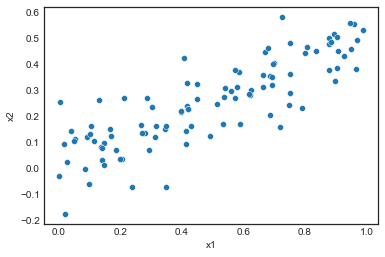

In [ ]:
sns.scatterplot(x='x1', y='x2', data=df);

print('Correlation coefficient: ' + str(np.corrcoef(x1, x2)[0][1]))

There is correlation between $x_1$ and $x_2$ with coefficient 0.839. The plot suggests a linear relationship with a gradient of around 0.5 and high variance.

### (c) Regression using $x_1$ and $x_2$

Using this data, fit a least squares regression to predict y using $x_1$ and $x_2$. Describe the results obtained. What are $\beta_0$, $\beta_1$, and $\beta_2$? How do these relate to the true $\beta_0$, $\beta_1$, and $\beta_2$? Can you reject the null hypothesis $H_0 : \beta_1 = 0$? How about the null hypothesis $H_0 : \beta_2 = 0$?

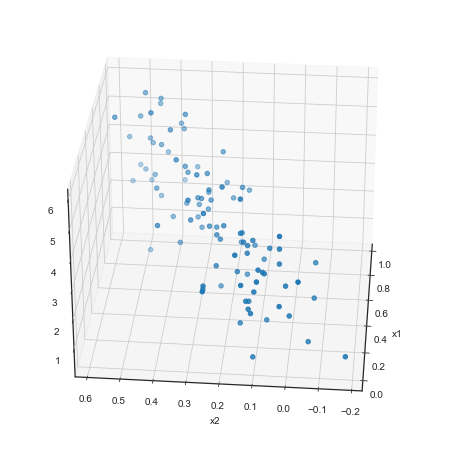

In [ ]:
plt.subplots(figsize=(8, 8))
ax = plt.subplot(111, projection='3d')
ax.scatter(df['x1'], df['x2'], df['y'])
ax.view_init(30, 185)
ax.set(xlabel='x1')
ax.set(ylabel='x2')
plt.show()

In [ ]:
f = 'y ~ x1 + x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           4.40e-07
Time:                        11:53:43   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.0

$\beta_0 = 2$  
$\beta_1 = 2$  
$\beta_2 = 0.3$ 

$\hat{\beta_0} = 2.1893$  
$\hat{\beta_1} = 0.7046$  
$\hat{\beta_2} = 2.5024$ 

- The intercept $\hat{\beta_0}$ is estimated fairly accurately.

- $\hat{\beta_1}$ and $\hat{\beta_2}$ are not well estimated. It's almost as though our model has got these the wrong way around.

- we cannot reject the null hypothesis for $\hat{\beta_1}$

- we can reject the null hypothesis for $\hat{\beta_2}$

### (d) Regression using $x_1$

Now fit a least squares regression to predict $y$ using only $x_1$. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_1 = 0$?

In [ ]:
f = 'y ~ x1'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           6.68e-07
Time:                        11:53:43   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.0

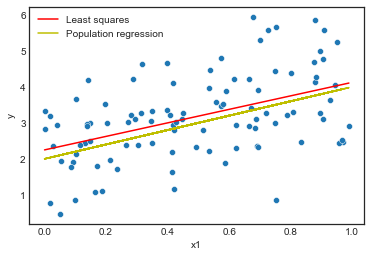

In [ ]:
ax = sns.scatterplot(x='x1', y='y', data=df)

ax.set(xlabel='x1')
ax.set(ylabel='y')
ax.plot(df['x1'].sort_values(), model.predict(df['x1'].sort_values()), color='r')
ax.plot(x1, 2+(2*x1), color='y')
ax.legend(['Least squares', 'Population regression'])

### (e) Regression using $x_2$

Now fit a least squares regression to predict $y$ using only $x_2$. Comment on your results. Can you reject the null hypothesis $H_0 : \beta_1 = 0$?

In [ ]:
f = 'y ~ x2'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           1.09e-07
Time:                        11:53:44   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.0

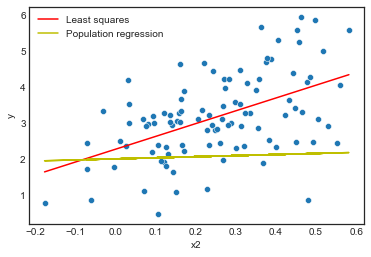

In [ ]:
ax = sns.scatterplot(x='x2', y='y', data=df)
ax.set(xlabel='x2')
ax.set(ylabel='y')
ax.plot(df['x2'].sort_values(), model.predict(df['x2'].sort_values()), color='r')
ax.plot(x2, 2+(0.3*x2), color='y')
ax.legend(['Least squares', 'Population regression'])

### (f) Contradict ?

Do the results obtained in (c)~(e) contradict each other? Explain your answer.

$β_1$

- result c) suggests probability < 0.271 that the null hypothesis $H_0 :β_1 =0$ is true

- result d) suggests probability < 0.000 that the null hypothesis $H_0 :β_1 =0$ is true

$β_2$

- result c) suggests probability < 0.031 that the null hypothesis $H_0 :β_2 =0$ is true
    
- result e) suggests probability < 0.000 that the null hypothesis $H_0 :β_2 =0$ is true

Yes. We get contradictory results for the p-value associated with $\beta_1$, which in results c woul cause us to accept the null hypothesis and in d) we would reject it.

This contradiction can be explained by the collinearity of $x_1$ and $x_2$ which causes an increased standard error for all $\beta_j$ when our model incorporates both features, which in turn increases the p-values and causes us to incorrectly accept the null hypothesis $H_0 :\beta_1 =0$ when our model uses both features.

### (g) A mismeasured observation

Now suppose we obtain one additional observation, which was unfortunately mismeasured.

```
x1=c(x1, 0.1) 
x2=c(x2, 0.8)
y=c(y,6)
```
Re-fit the linear models from (c) ~ (e) using this new data. What effect does this new observation have on the each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.

In [ ]:
df2 = df.append({'x1': 0.1, 'x2': 0.8, 'y': 6}, ignore_index=True)

model_c = smf.ols(formula='y ~ x1 + x2', data=df2).fit()
model_d = smf.ols(formula='y ~ x1', data=df2).fit()
model_e = smf.ols(formula='y ~ x2', data=df2).fit()

- The addition of this anomaly has increased model c's p-value for $\hat{\beta_1}$, suggesting even more strongly the false acceptance of the null hpyothesis.

- When considered seperately the estimates for $\hat{\beta_1}$ and $\hat{\beta_2}$ are worsened by introducing this anomaly.

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no property 'fontweight'

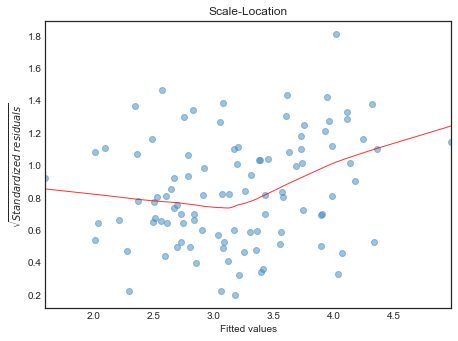

In [ ]:
lm_plots(model_c)

In [ ]:
lm_plots(model_d)

In [ ]:
lm_plots(model_e)

- model_c : the anomaly is not an outlier and very high leverage

- model_d : the anomaly is an outlier but not high leverage

- model_e : the anomaly is not an outlier but fairly high leverage

## 15. Boston data set

### (a) Simple linear regression

For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()
boston = pd.DataFrame(boston.data, columns=boston.feature_names)

assert boston.isnull().sum().sum() == 0

models_a = [smf.ols(formula='CRIM ~ {}'.format(f), data=boston).fit()
            for f in boston.columns[1:]]

for model in models_a:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.4537,0.4172,10.6747,0.0,3.6340,5.2734
ZN,-0.0739,0.0161,-4.5938,0.0,-0.1056,-0.0423


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.0637,0.6672,-3.0930,0.0021,-3.3746,-0.7529
INDUS,0.5098,0.0510,9.9908,0.0000,0.4095,0.6100


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7444,0.3961,9.4530,0.0000,2.9662,4.5227
CHAS,-1.8928,1.5061,-1.2567,0.2094,-4.8518,1.0663


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-13.7199,1.6995,-8.073,0.0,-17.0588,-10.3809
NOX,31.2485,2.9992,10.419,0.0,25.3561,37.1410


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,20.4818,3.3645,6.0877,0.0,13.8717,27.0919
RM,-2.6841,0.5320,-5.0448,0.0,-3.7293,-1.6388


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.7779,0.9440,-4.0021,0.0001,-5.6325,-1.9233
AGE,0.1078,0.0127,8.4628,0.0000,0.0828,0.1328


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,9.4993,0.7304,13.0056,0.0,8.0643,10.9343
DIS,-1.5509,0.1683,-9.2135,0.0,-1.8816,-1.2202


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.2872,0.4435,-5.1573,0.0,-3.1584,-1.4159
RAD,0.6179,0.0343,17.9982,0.0,0.5505,0.6854


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-8.5284,0.8158,-10.4539,0.0,-10.1312,-6.9256
TAX,0.0297,0.0018,16.0994,0.0,0.0261,0.0334


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-17.6469,3.1473,-5.6071,0.0,-23.8303,-11.4635
PTRATIO,1.1520,0.1694,6.8014,0.0,0.8192,1.4847


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,16.5535,1.4259,11.6092,0.0,13.7521,19.3550
B,-0.0363,0.0039,-9.3670,0.0,-0.0439,-0.0287


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.3305,0.6938,-4.8007,0.0,-4.6936,-1.9675
LSTAT,0.5488,0.0478,11.4907,0.0,0.4550,0.6426


In [ ]:
from IPython.display import display, HTML

display(HTML('<h4>p < 0.05</h4>'))
for model in models_a:
    if model.pvalues[1] < 0.05:
        print(model.params[1:].index[0])

display(HTML('<h4>p > 0.05</h4>'))
for model in models_a:
    if model.pvalues[1] > 0.05:
        print(model.params[1:].index[0])

ZN
INDUS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


CHAS


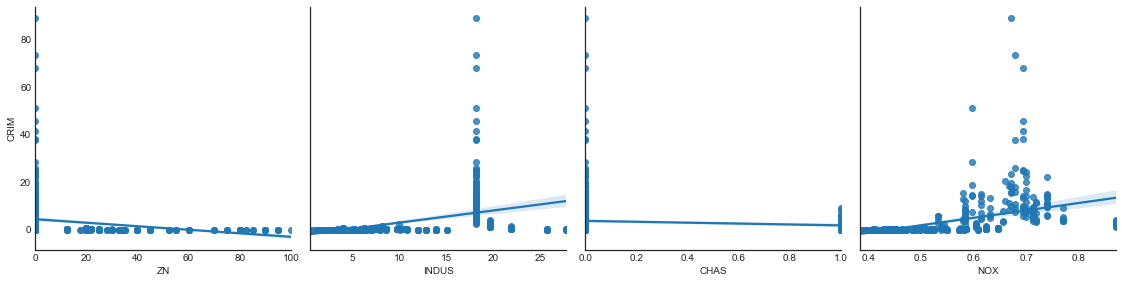

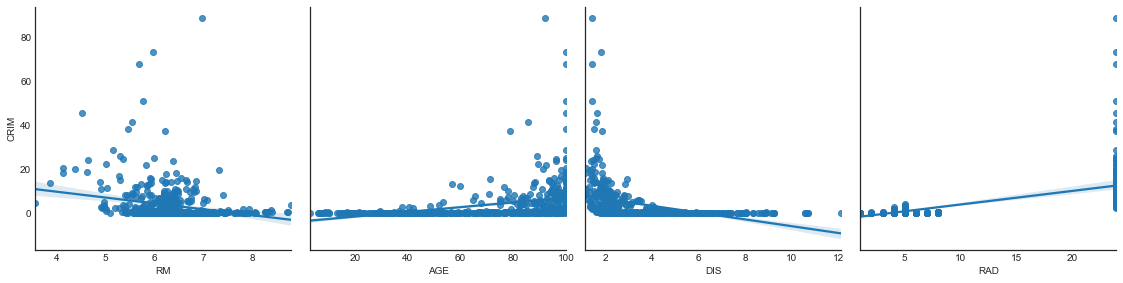

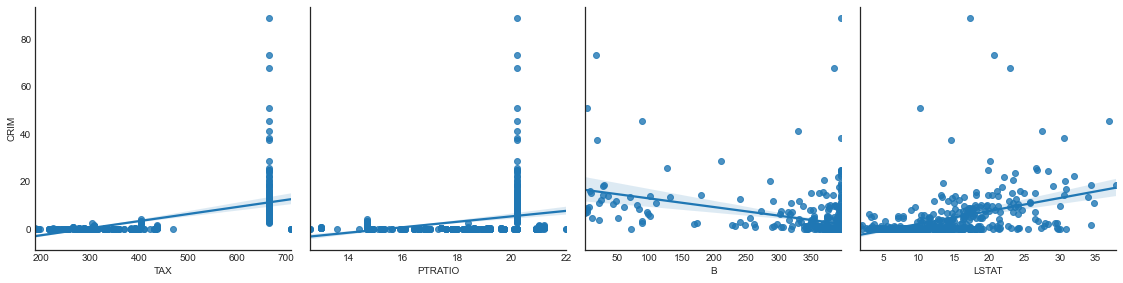

In [ ]:
def plot_grid(df, response, cols):
    variables = df.columns.drop(response)
    for i in range(0, len(variables), cols):
        g = sns.PairGrid(df, y_vars=[response], x_vars=variables[i:i+cols], height=4)
        g.map(sns.regplot);
    return

plot_grid(boston, 'CRIM', 4)

### (b) Multivariate regression

Fit a multivariate regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$?

In [ ]:
response   = 'CRIM'
predictors = boston.columns.drop(response)
f = '{} ~ {}'.format(response, '+'.join(predictors))

model_b = smf.ols(formula=f, data=boston).fit()
model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   CRIM   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     32.55
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           4.84e-55
Time:                        11:53:51   Log-Likelihood:                -1658.8
No. Observations:                 506   AIC:                             3344.
Df Residuals:                     493   BIC:                             3398.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9967      6.979      1.432      0.153      -3.716      23.709
ZN             0.0364      0.019      1.943      0.053      -0.000       0.073
INDUS         -0.0694      0.084     -0.825      0.410      -0.235       0.096
CHAS          -1.3117      1.179     -1.112      0.267      -3.629       1.005
NOX           -6.9288      5.225     -1.326      0.185     -17.195       3.338
RM            -0.3348      0.573     -0.585      0.559      -1.460       0.790
AGE            0.0013      0.018      0.074      0.941      -0.034       0.037
DIS           -0.7089      0.271     -2.612      0.009      -1.242      -0.176
RAD            0.5389      0.088      6.151      0.000       0.367       0.711
TAX           -0.0014      0.005     -0.263      0.793      -0.011       0.009
PTRATIO       -0.0834      0.179     -0.465      0.642      -0.436       0.269
B             -0.0096      0.004     -2.625      0.009      -0.017      -0.002
LSTAT          0.2356      0.069      3.431      0.001       0.101       0.371
==============================================================================
Omnibus:                      685.174   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97204.794
Skew:                           6.921   Prob(JB):                         0.00
Kurtosis:                      69.475   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
display(HTML('<h4>p < 0.05</h4>'))

model_b.pvalues[model_b.pvalues < 0.05]

DIS      9.2874e-03
RAD      1.5976e-09
B        8.9317e-03
LSTAT    6.5241e-04
dtype: float64

### (c) Comparison

How do your results from (a) compare to your results from (b)? Create a plot displaying the univariate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

Multivariate regression found 4 of 12 predictors to be significnat where univariate regression found 11 of 12 significant. Multivariate regression seems to find significanlty less predictors to be significant.

,Univariate_coef,Multivariate_coef
ZN,-0.0739,0.0364
INDUS,0.5098,-0.0694
CHAS,-1.8928,-1.3117
NOX,31.2485,-6.9288
RM,-2.6841,-0.3348
AGE,0.1078,0.0013
DIS,-1.5509,-0.7089
RAD,0.6179,0.5389
TAX,0.0297,-0.0014
PTRATIO,1.1520,-0.0834


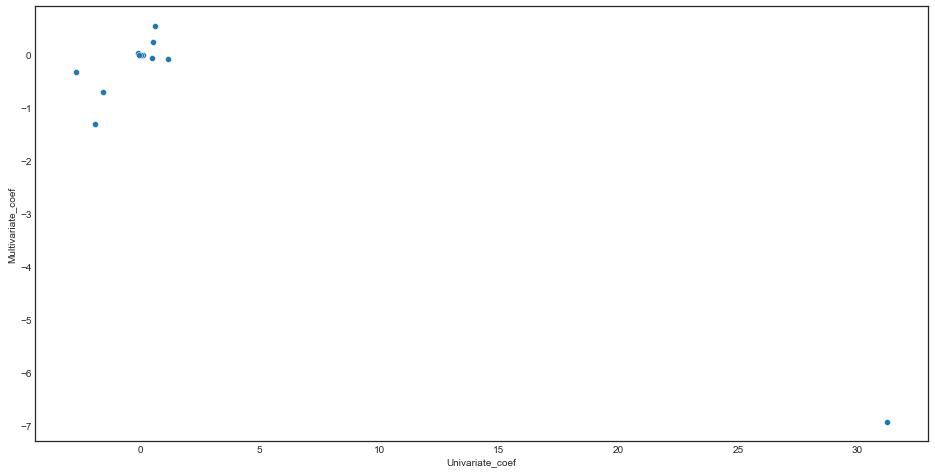

In [ ]:
univariate_params = pd.concat([m.params[1:] for m in models_a])
multivariate_params = model_b.params[1:]

df = pd.DataFrame({'Univariate_coef': univariate_params, 
                   'Multivariate_coef': multivariate_params,})
display(df)

plt.subplots(figsize=(16, 8))
ax = sns.scatterplot(x='Univariate_coef', y='Multivariate_coef', data=df)

### (d) Non-linear association

Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form

$Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon$

In [ ]:
models_d = [smf.ols(formula='CRIM ~ {0} + np.power({0}, 2) + np.power({0}, 3)'.format(f), data=boston).fit()
            for f in boston.columns[1:]]

for model in models_d:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.8461,0.4330,11.1922,0.0000,3.9954,5.6967
ZN,-0.3322,0.1098,-3.0252,0.0026,-0.5479,-0.1164
"np.power(ZN, 2)",0.0065,0.0039,1.6791,0.0938,-0.0011,0.0141
"np.power(ZN, 3)",-0.0000,0.0000,-1.2030,0.2295,-0.0001,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.6626,1.5740,2.3269,0.0204,0.5702,6.7550
INDUS,-1.9652,0.4820,-4.0773,0.0001,-2.9122,-1.0182
"np.power(INDUS, 2)",0.2519,0.0393,6.4070,0.0000,0.1747,0.3292
"np.power(INDUS, 3)",-0.0070,0.0010,-7.2920,0.0000,-0.0089,-0.0051


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7444,0.3961,9.4530,0.0000,2.9662,4.5227
CHAS,-0.6309,0.5020,-1.2567,0.2094,-1.6173,0.3554
"np.power(CHAS, 2)",-0.6309,0.5020,-1.2567,0.2094,-1.6173,0.3554
"np.power(CHAS, 3)",-0.6309,0.5020,-1.2567,0.2094,-1.6173,0.3554


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,233.0866,33.6431,6.9282,0.0,166.9880,299.1852
NOX,-1279.3713,170.3975,-7.5082,0.0,-1614.1513,-944.5912
"np.power(NOX, 2)",2248.5441,279.8993,8.0334,0.0,1698.6257,2798.4624
"np.power(NOX, 3)",-1245.7029,149.2816,-8.3446,0.0,-1538.9966,-952.4091


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,112.6246,64.5172,1.7457,0.0815,-14.1325,239.3817
RM,-39.1501,31.3115,-1.2503,0.2118,-100.6679,22.3676
"np.power(RM, 2)",4.5509,5.0099,0.9084,0.3641,-5.2920,14.3938
"np.power(RM, 3)",-0.1745,0.2637,-0.6615,0.5086,-0.6927,0.3437


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.5488,2.7691,-0.9204,0.3578,-7.9893,2.8918
AGE,0.2737,0.1864,1.4683,0.1427,-0.0925,0.6398
"np.power(AGE, 2)",-0.0072,0.0036,-1.9878,0.0474,-0.0144,-0.0001
"np.power(AGE, 3)",0.0001,0.0000,2.7237,0.0067,0.0000,0.0001


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,30.0476,2.4459,12.2850,0.0,25.2422,34.8530
DIS,-15.5544,1.7360,-8.9600,0.0,-18.9650,-12.1437
"np.power(DIS, 2)",2.4521,0.3464,7.0783,0.0,1.7715,3.1327
"np.power(DIS, 3)",-0.1186,0.0204,-5.8135,0.0,-0.1587,-0.0785


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-0.6055,2.0501,-0.2954,0.7678,-4.6334,3.4223
RAD,0.5127,1.0436,0.4913,0.6234,-1.5376,2.5631
"np.power(RAD, 2)",-0.0752,0.1485,-0.5061,0.6130,-0.3670,0.2167
"np.power(RAD, 3)",0.0032,0.0046,0.7031,0.4823,-0.0058,0.0122


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,19.1836,11.7955,1.6263,0.1045,-3.9911,42.3583
TAX,-0.1533,0.0957,-1.6023,0.1097,-0.3413,0.0347
"np.power(TAX, 2)",0.0004,0.0002,1.4877,0.1375,-0.0001,0.0008
"np.power(TAX, 3)",-0.0000,0.0000,-1.1668,0.2439,-0.0000,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,477.1840,156.7950,3.0434,0.0025,169.1288,785.2393
PTRATIO,-82.3605,27.6439,-2.9793,0.0030,-136.6726,-28.0485
"np.power(PTRATIO, 2)",4.6353,1.6083,2.8821,0.0041,1.4755,7.7952
"np.power(PTRATIO, 3)",-0.0848,0.0309,-2.7433,0.0063,-0.1455,-0.0241


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,18.2637,2.3049,7.9238,0.0000,13.7353,22.7921
B,-0.0836,0.0563,-1.4834,0.1386,-0.1942,0.0271
"np.power(B, 2)",0.0002,0.0003,0.7162,0.4742,-0.0004,0.0008
"np.power(B, 3)",-0.0000,0.0000,-0.6078,0.5436,-0.0000,0.0000


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,1.2010,2.0286,0.5920,0.5541,-2.7847,5.1866
LSTAT,-0.4491,0.4649,-0.9660,0.3345,-1.3624,0.4643
"np.power(LSTAT, 2)",0.0558,0.0301,1.8522,0.0646,-0.0034,0.1149
"np.power(LSTAT, 3)",-0.0009,0.0006,-1.5170,0.1299,-0.0020,0.0003


In [ ]:
# In which of the models is there a statistically significant association between the predictor and the response?

display(HTML('<h4>Features with p < 0.05</h4>'))

sig = pd.concat([model.pvalues[model.pvalues < 0.05] for model in models_d])

display(pd.DataFrame({'P>|t|':sig.drop('Intercept')}))

,P>|t|
ZN,2.6123e-03
INDUS,5.2971e-05
"np.power(INDUS, 2)",3.4202e-10
"np.power(INDUS, 3)",1.1964e-12
NOX,2.7584e-13
"np.power(NOX, 2)",6.8113e-15
"np.power(NOX, 3)",6.9611e-16
"np.power(AGE, 2)",4.7377e-02
"np.power(AGE, 3)",6.6799e-03
DIS,6.3748e-18


- There is evidence of a non-linear association between the repsonse and INDUS, NOX, AGE, DIS, PTRATIO

- There is evidence of a linear association between the response and ZN